In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = pd.read_csv('Base.csv')

In [3]:
data.head()

,Unnamed: 0,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,...,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
0,0,1996-97,1610612765,DET,Detroit Pistons,29601185,1997-04-20T00:00:00,DET @ IND,W,53.0,...,1656,1586,355,1648,1228,462,1700,358,34,929
1,1,1996-97,1610612764,WAS,Washington Bullets,29601184,1997-04-20T00:00:00,WAS @ CLE,W,48.0,...,499,1767,355,2258,887,1493,1106,22,1961,929
2,2,1996-97,1610612761,TOR,Toronto Raptors,29601182,1997-04-20T00:00:00,TOR @ BOS,W,48.0,...,1973,563,2,46,887,1,691,358,26,26
3,3,1996-97,1610612766,CHH,Charlotte Hornets,29601186,1997-04-20T00:00:00,CHH @ MIL,L,48.0,...,2210,1586,1200,1033,1918,800,251,358,905,2214
4,4,1996-97,1610612759,SAS,San Antonio Spurs,29601187,1997-04-20T00:00:00,SAS vs. HOU,L,48.0,...,499,1247,36,1919,887,1152,898,22,980,1366


In [21]:
data['WL_numeric'] = data['WL'].map({'W':1,'L':0})
data['HOME_GAME'] = data['MATCHUP'].str.contains(' vs. ').astype(int)
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])
data = data.sort_values(by='GAME_DATE')

In [38]:
# important to shift data so that the team record is before the game
# for winning first game of every season is null so fill with 0.5 
# for margin fill the first game with 0
data['TEAM_WL_PCT'] = data.groupby(['TEAM_ID','SEASON_YEAR'])[['WL_numeric']].apply(lambda x: x.expanding().mean().shift()).fillna(0.5)
data['TEAM_PLUS_MINUS'] = data.groupby(['TEAM_ID','SEASON_YEAR'])[['PLUS_MINUS']].apply(lambda x: x.expanding().mean().shift()).fillna(0)

In [39]:
home_games = data[data['HOME_GAME']==1].copy()
away_games = data[data['HOME_GAME']==0].copy()
df = home_games.merge(away_games,on='GAME_ID',suffixes=('','_OPP'))

### Basic predictor:
1. Home team always wins
2. If home team as a better winning % before the game then predict home team wins. If equal record predict home team wins
3. Look at average margins before the game, add 3 points for the home team. Team with higher margin wins.  

In [40]:
df['predict_outcome_by_margin'] = np.where(df['TEAM_PLUS_MINUS'] + 3 >= df['TEAM_PLUS_MINUS_OPP'],1,0)
df['predict_outcome_by_record'] = np.where(df['TEAM_WL_PCT'] >= df['TEAM_WL_PCT_OPP'],1,0)
df['predict_outcome_by_home'] = 1

In [41]:
df['correct_prediction_by_record'] = np.where(df['WL_numeric']==df['predict_outcome_by_record'],1,0)
df['correct_prediction_by_margin'] = np.where(df['WL_numeric']==df['predict_outcome_by_margin'],1,0)
df['correct_prediction_by_home'] = np.where(df['WL_numeric']==df['predict_outcome_by_home'],1,0)

Text(0, 0.5, 'Prediction Success')

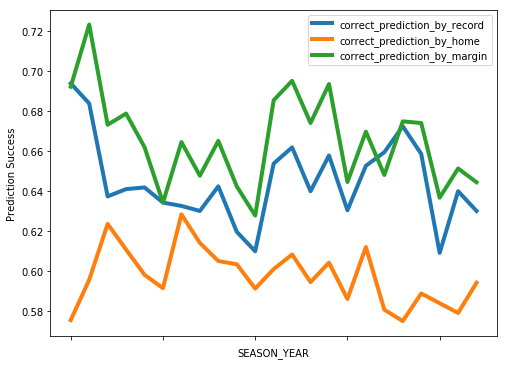

In [42]:
ax = df.groupby('SEASON_YEAR')[['correct_prediction_by_record','correct_prediction_by_home','correct_prediction_by_margin']].mean().plot(figsize=(8,6),linewidth=4)
ax.set_ylabel('Prediction Success')